# Abalone Shell Data: Higher Order Models

<br />
<br />
<br />

### Table of Contents

* [Introduction](#intro)
* [scikit-learn: Support Vector Regression](#scikit_svr)
 * [Linear SVR](#svr_linear)
 * [Polynomial SVR](#svr_poly)
 * [RBF SVR](#svr_rbf)
* [SVR with Scaling](#svr_scaling)
* [Improving the SVR Model](#improving_svr)

<br />
<br />
<br />

<a name="intro"></a>
## Introduction

In a prior notebook, we performed a linear analysis of a data set consisting of physical measurements of abalones (sea snails). We saw in that notebook that linear models do not capture higher-order effects and the interactions of variables. 

In this notebook we'll utilize models with higher-order interaction terms and explore different variable transformations. We mentioned the two principal ways to do this: the first way is to add, by hand, any variable transformations that we think might be important, and analyze the results by hand to determine if, in fact, the interaction is significant. The second way is to utilize different kernels to perform support vector regression, which (depending on the kernel) can automatically deduce which of the (potentially thousands of) variable transformations work best.

The snippets of code below will load and transform data, as well as remove outliers whose physical dimensions are not sensible.

In [1]:
%matplotlib inline

# numbers
import numpy as np
import pandas as pd

# stats
import statsmodels.api as sm
import scipy.stats as stats

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import os, re

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Copy-and-paste from prior notebook

def abalone_load(data_file, infant=False):
    # x data labels
    xnlabs = ['Sex']
    xqlabs = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
    xlabs = xnlabs + xqlabs

    # y data labels
    ylabs = ['Rings']

    # data
    df = pd.read_csv(data_file, header=None, sep=' ', names=xlabs+ylabs)
    
    if(infant):
        new_df = df[ df['Sex']=='I' ]
    else:
        new_df = df[ df['Sex']<>'I' ]
    return new_df

def infant_abalone_load(data_file):
    return abalone_load(data_file,True)

def adult_abalone_load(data_file):
    return abalone_load(data_file,False)

def abalone_removeoutliers(df,mse_tol,verbose=False):
    df.loc[:,'Volume'] = df['Length'].values*df['Diameter'].values*df['Height'].values

    X = df['Volume']
    Y = df['Shell weight']
    lin = sm.OLS(Y,X).fit()

    Yhat = lin.predict(df['Volume'])
    df.loc[:,'Predicted shell weight'] = Yhat
    df.loc[:,'Residual'] = Y - Yhat
    df.loc[:,'MSE'] = (Y - Yhat)**2
    MSE = df['MSE']

    original_length = len(df)
    thresh = 0.5
    df = df[df['MSE'] < thresh]
    df = df[ df['Height'] < 0.30 ]
    new_length = len(df)
    records_removed = original_length - new_length
    
    if(verbose):
        print "Number of data points removed: %d"%(records_removed)
        print "%0.2f%% of data was removed"%((float(records_removed)/len(df))*100)
    
    del df['Predicted shell weight']
    del df['Residual']
    del df['MSE']
    del df['Volume']
    
    return df

def infant_abalone_removeoutliers(df):
    return abalone_removeoutliers(df,0.5)
    
def adult_abalone_removeoutliers(df):
    return abalone_removeoutliers(df,1.0)

In [3]:
# x data labels
xnlabs = ['Sex']
xqlabs = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
xlabs = xnlabs + xqlabs

# y data labels
ylabs = ['Rings']

In [4]:
inf_df = infant_abalone_removeoutliers(infant_abalone_load('abalone/Dataset.data'))
adt_df = adult_abalone_removeoutliers(adult_abalone_load('abalone/Dataset.data'))
adt_df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20


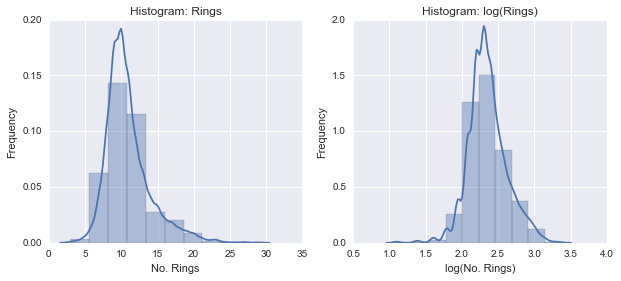

In [5]:
fig = plt.figure(figsize=(10,4))
(ax1,ax2) = (fig.add_subplot(121), fig.add_subplot(122))

sns.distplot(adt_df['Rings'], bins=10, ax=ax1)
sns.distplot(adt_df['Rings'].map(lambda x : np.log(x)), bins=10, ax=ax2)

ax1.set_title('Histogram: Rings')
ax1.set_xlabel('No. Rings')
ax1.set_ylabel('Frequency')

ax2.set_title('Histogram: log(Rings)')
ax2.set_xlabel('log(No. Rings)')
ax2.set_ylabel('Frequency')

plt.show()

## scikit-learn: Support Vector Regression

We covered support vector regression earlier - this is a regression technique that utilizes kernels (defined in terms of integral convolutions of functions) to find the most efficient way of combining variables; the possible combinations of variables is defined by the kernel choice. 

<a name="svr_linear"></a>
### Linear SVR

Let's review again how we construct a linear support vector regression model, and how it performs:

In [6]:
from sklearn.svm import SVR

The `C` parameter is the error penalty term: the larger C is, the longer it will take to train the model.

In [7]:
# ~5 seconds
svr_lin = SVR(kernel='linear', C=1e3)
svr_lin = svr_lin.fit( adt_df[xqlabs], adt_df['Rings'].values )

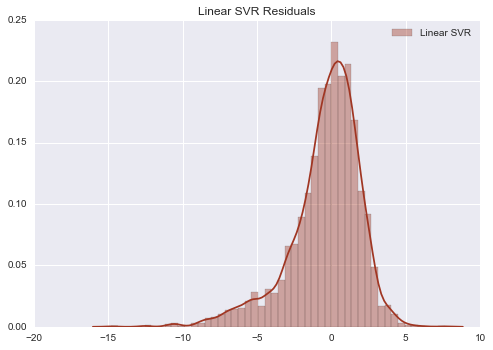

In [8]:
y = adt_df['Rings'].values
yhat_lin = svr_lin.predict(adt_df[xqlabs])

svr_lin_resid = yhat_lin - y

sns.distplot(svr_lin_resid,  color=sns.xkcd_rgb['brick'], label='Linear SVR')

plt.title('Linear SVR Residuals')
plt.legend()
plt.show()

The state vector regression algorithm results in a linear model with large residuals that are not normally distributed - meaning our predictions will be off by a substantial amount. This was what motivated a need for higher-order models.

To introduce a more complex kernel, we have a couple of choices of pre-configured kernels:
* Linear (`'linear'`) - what we were using before, response is linear with respect to each variable
* Polynomial (`'poly'`) - a kernel including polynomial interaction effects
* RBF (`'rbf'`) - radial basis function (decaying squared exponential)
* Sigmoid (`'sigmoid'`) - S-curve function fit

We'll start with the polynomial kernel, and go from there.

<a name="svr_poly"></a>
### Polynomial SVR

We can pass `'poly'` to the kernel argument to perform SVR with a polynomial kernel, which will include interaction effects between variables. We can start with degree 2 (it turns out the fit gets worse as the degree increases) - when we do that, here are the residuals we get:

In [9]:
# ~15 seconds
svr_poly = SVR(kernel='poly', degree=2, C=1e4)
svr_poly = svr_poly.fit( adt_df[xqlabs], adt_df['Rings'].values )

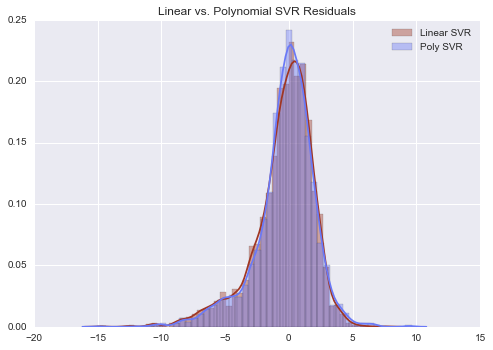

In [10]:
y = adt_df['Rings'].values
yhat_poly = svr_poly.predict(adt_df[xqlabs])

svr_poly_resid = yhat_poly - y

sns.distplot(svr_lin_resid,  color=sns.xkcd_rgb['brick'], label='Linear SVR')
sns.distplot(svr_poly_resid,  color=sns.xkcd_rgb['cornflower'], label='Poly SVR')

plt.title('Linear vs. Polynomial SVR Residuals')
plt.legend()
plt.show()

This result is a bit disappointing - adding interaction terms to our sVR model still gets us no noticeable improvements.

In [11]:
print svr_lin.score( adt_df[xqlabs], adt_df['Rings'].values)

0.378779672049


In [12]:
print svr_poly.score( adt_df[xqlabs], adt_df['Rings'].values)

0.409661760571


<a name="svr_rbf"></a>
### Radial Basis Function (RBF)

Next we'll try state vector regression with a radial basis function as our kernel. The radial basis function is a squared exponential function.

In [13]:
# ~10 seconds
svr_rbf = SVR(kernel='rbf', C=1e4)
svr_rbf = svr_rbf.fit( adt_df[xqlabs], adt_df['Rings'].values )

In [14]:
print svr_rbf.score( adt_df[xqlabs], adt_df['Rings'].values)

0.442661372179


In [15]:
#svr_rbf2 = SVR(kernel='rbf', C=1e6)
#svr_rbf2 = svr_rbf2.fit( adt_df[xqlabs], adt_df['Rings'].values )
#print svr_rbf2.score( adt_df[xqlabs], adt_df['Rings'].values)

# The score that results is 0.4562

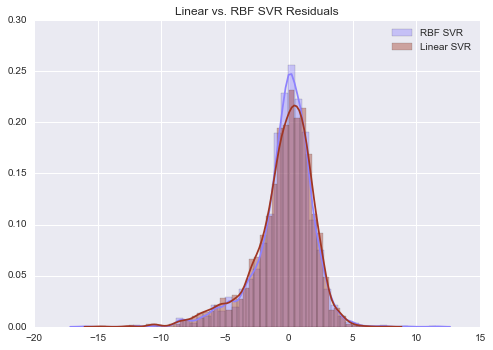

In [16]:
y = adt_df['Rings'].values
yhat_rbf = svr_rbf.predict(adt_df[xqlabs])

svr_rbf_resid = yhat_rbf - y

sns.distplot(svr_rbf_resid,  color=sns.xkcd_rgb['periwinkle'], label='RBF SVR')
sns.distplot(svr_lin_resid,  color=sns.xkcd_rgb['brick'], label='Linear SVR')

plt.title('Linear vs. RBF SVR Residuals')
plt.legend()
plt.show()

<a name="svr_scaling"></a>
## SVR with Scaling

The scores for these state vector regression models can be improved by scaling the input variables.

In [17]:
from sklearn import preprocessing

In [18]:
scaler = preprocessing.StandardScaler().fit(adt_df[xqlabs])
X = scaler.transform(adt_df[xqlabs])

In [19]:
# This takes 3 minutes
svr_rbf3 = SVR(kernel='rbf', C=1e4)
svr_rbf3 = svr_rbf3.fit( X, adt_df['Rings'].values )

In [23]:
print svr_rbf3.score( X, adt_df['Rings'].values )

0.589419273831


The $R^2$ statistic is a measure of how much of the variance in the data is explained by the state vector regression model. 

A value of 0.589 means that there is still about 40% of the variance from the mean that is not explained (or, fit) by the model. This is much improved, however, over a vlaue of less than 0.4, which we saw with linear models.

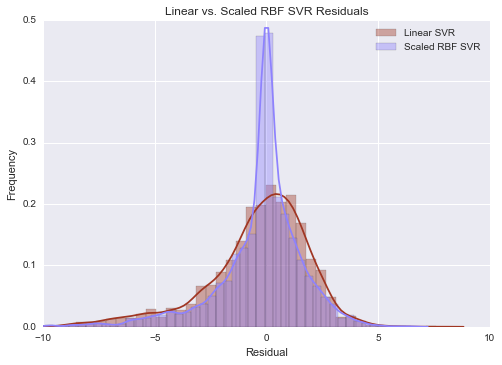

In [24]:
y = adt_df['Rings'].values
yhat_rbf3 = svr_rbf3.predict(X)

svr_rbf3_resid = yhat_rbf3 - y

sns.distplot(svr_lin_resid,   color=sns.xkcd_rgb['brick'], label='Linear SVR')
sns.distplot(svr_rbf3_resid,  color=sns.xkcd_rgb['periwinkle'], label='Scaled RBF SVR')

plt.title('Linear vs. Scaled RBF SVR Residuals')
plt.xlim([-10,10])
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.legend()
plt.show()

The residual is more tightly clustered around 0, so the scaling helped - but the tails of the distribution are still significant. If we look at a quantile plot of the model residuals, we can see that a significant number of residuals don't follow a normal distribution:

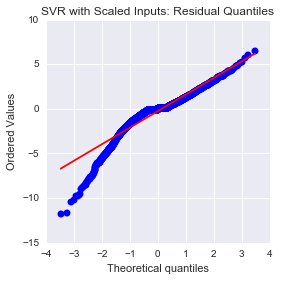

In [25]:
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)

stats.probplot(svr_rbf3_resid, dist='norm', plot=ax1)

ax1.set_title('SVR with Scaled Inputs: Residual Quantiles')

plt.show()

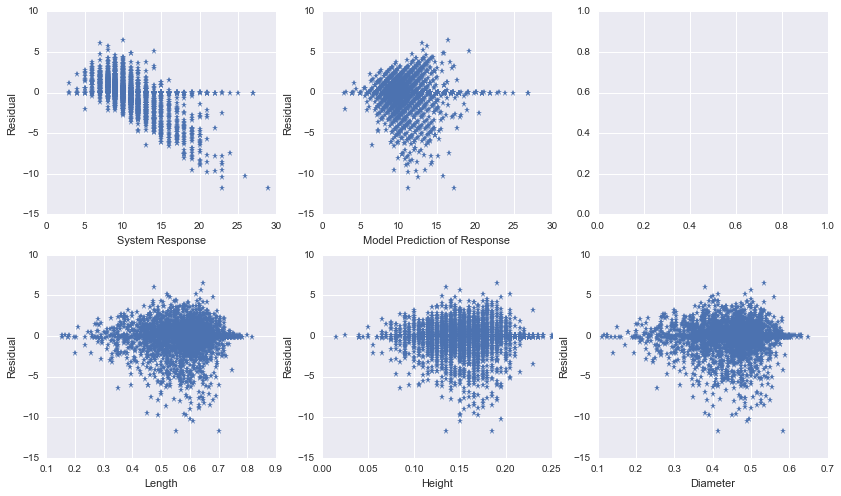

In [26]:
fig = plt.figure(figsize=(14,8))

ax1,ax2,ax3 = fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233)
ax4,ax5,ax6 = fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236)

ax1.plot(y,svr_rbf3_resid,'*')
ax1.set_xlabel('System Response')

ax2.plot(yhat_rbf3,svr_rbf3_resid,'*')
ax2.set_xlabel('Model Prediction of Response')
ax2.set_ylabel('Residual (Normalized RBF SVR)')

ax4.plot(adt_df['Length'],svr_rbf3_resid,'*')
ax4.set_xlabel('Length')

ax5.plot(adt_df['Height'],svr_rbf3_resid,'*')
ax5.set_xlabel('Height')

ax6.plot(adt_df['Diameter'],svr_rbf3_resid,'*')
ax6.set_xlabel('Diameter')


ax1.set_ylabel('Residual')
ax2.set_ylabel('Residual')

ax4.set_ylabel('Residual')
ax5.set_ylabel('Residual')
ax6.set_ylabel('Residual')

plt.show()

From the plot of system response $y$ versus residuals $\hat{y} - y$, we can see a pretty clear trend: model residuals still have functional dependence on the response value. Residuals that are more negative as the system response gets larger means that we are systematically overpredicting the age of younger abalones and underpredicting the age of older abalones. There is also a slight functional dependence of the residual on length, height, and diameter - as these quantities get larger, the residual also gets larger.

From this, we can conclude that support vector regression, which explores different variable interactions, together with scaling of variables, leads to a better fit - but still doesn't capture all of the higher-order effects. This information can help guide choices of next steps.

<a name="improving_svr"></a>
## Improving the SVR Model

Methods for improving fit:
* Including another variable in the mix - volume, dimension, or non-dimensional number
* System response is an integer - but model prediction is a float. Can use a classifier, with number of rings as labels, or can round model prediction up/down to nearest integer